# Part 3: Practical applications of the FFT in Python

## Frequency domain filtering

Images will often contain unwanted components at certain ranges of frequencies. These can often be removed by filtering operations performed in the frequency domain. Filters typicall fall into three classes:
1. **Low-pass filters:** Remove high frequency components of the signal.
2. **High-pass filters:** Remove low frequency components of the signal.
3. **Band-pass filters:** Remove frequencies outside of a specified continuous range.

Lets take a look at the application of these three filter types:

In [1]:
from skimage.data import camera
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift

import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-colorblind')
font = {'size': 18}

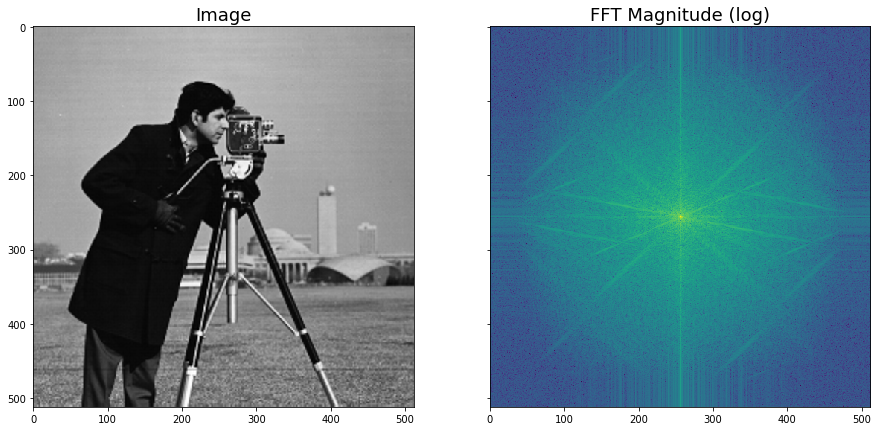

In [2]:
# First look at Image and corresponding FFT

image = camera()
image_fft = fftshift(fftn(image))

# Plot
fig, ax = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Image', fontdict=font)
ax[1].imshow(np.log(np.abs(image_fft))) # Notice the log transform!
ax[1].set_title('FFT Magnitude (log)', fontdict=font);

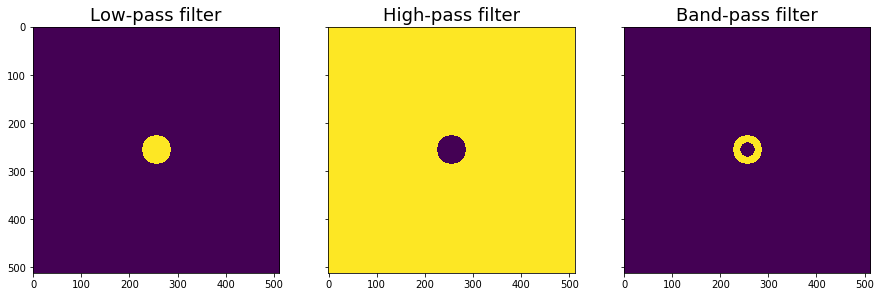

In [3]:
# Create some filters and plot them

from skimage.draw import circle

cutoff = 30 # Play with this value
center = (np.array(image.shape)[:2] / 2) - 0.5

# Low-pass filter
lpf = np.zeros_like(image)
lpf[circle(*center, cutoff)] = 1

# High-pass filter
hpf = np.ones_like(image)
hpf[circle(*center, cutoff)] = 0

# Band-pass filter
bpf = lpf.copy()
bpf[circle(*center, cutoff / 2)] = 0

# Plot
fig, ax = plt.subplots(ncols=3, figsize=(15, 10), sharey=True)
ax[0].imshow(lpf)
ax[0].set_title('Low-pass filter', fontdict=font)
ax[1].imshow(hpf)
ax[1].set_title('High-pass filter', fontdict=font)
ax[2].imshow(bpf)
ax[2].set_title('Band-pass filter', fontdict=font);

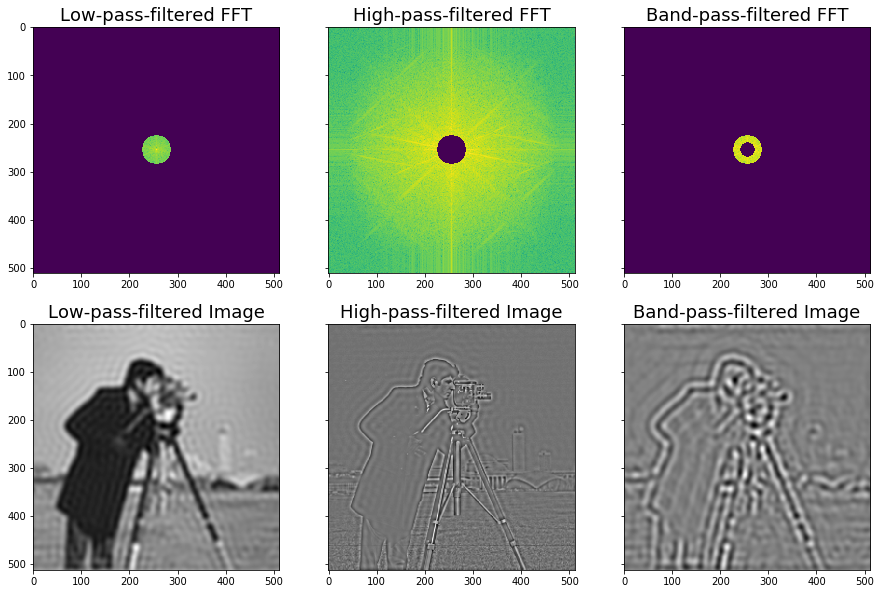

In [4]:
# Apply filters to the FFT
lp_filtered_fft = image_fft * lpf
hp_filtered_fft = image_fft * hpf
bp_filtered_fft = image_fft * bpf

# convert back to spatial domain from frequency domain
lp_filtered_image = ifftn(ifftshift(lp_filtered_fft))
hp_filtered_image = ifftn(ifftshift(hp_filtered_fft))
bp_filtered_image = ifftn(ifftshift(bp_filtered_fft))

lp_filtered_image = lp_filtered_image.real
hp_filtered_image = hp_filtered_image.real
bp_filtered_image = bp_filtered_image.real

# Plot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), sharey=True)
offset = 10 ** -6 # for avoiding divide-by-zero error

ax[0, 0].imshow(np.log(np.abs(lp_filtered_fft) + offset))
ax[0, 0].set_title('Low-pass-filtered FFT', fontdict=font)
ax[0, 1].imshow(np.log(np.abs(hp_filtered_fft) + offset))
ax[0, 1].set_title('High-pass-filtered FFT', fontdict=font)
ax[0, 2].imshow(np.log(np.abs(bp_filtered_fft) + offset))
ax[0, 2].set_title('Band-pass-filtered FFT', fontdict=font)
ax[1, 0].imshow(lp_filtered_image, cmap='gray')
ax[1, 0].set_title('Low-pass-filtered Image', fontdict=font)
ax[1, 1].imshow(hp_filtered_image, cmap='gray')
ax[1, 1].set_title('High-pass-filtered Image', fontdict=font)
ax[1, 2].imshow(bp_filtered_image, cmap='gray')
ax[1, 2].set_title('Band-pass-filtered Image', fontdict=font);

There are a few things worth mentioning about these filters. First, low-pass filters tend to smooth out (blur) your signal, whereas high-pass filters tend to highlight sharp transitions (e.g., edges). Bandpass filters produce an effect that is somewhat in-between, highlighting edges while filtering out image noise (which usually shows up as high frequency components).

You'll also notice a ripple effect in the images. These **ringing artifacts** are typically considered undesirable, and occur because the sharp cutoff in the Frequency domain. To better understand why this happens, think about simply removing high or low frequencies from the square wave example we covered in lesson 2. If you subtract a sine wave from an image that contains a lot of flat regions and edges, you'll create ripples!

To avoid the ripple artifacts, we need to be a little more thoughtful about how we remove high (or low) frequencies from our images. There are many approaches for creating better frequency domain filters, but a really simple (and computationally fast) approach is to make use of our friend the gaussian filter!

Because the gaussian filter acts as a low-pass filter (that doesn't have a hard cutoff in the frequency domain), not only can we use it directly for that purpose, we can also perform some basic arithmetic to create high-pass and band-pass filters.

**To create a high-pass filter**, we subtract a gaussian-filtered image from the original.

**To create a band-pass filter**, we create two gaussian-filtered images where the gaussian kernels differ with respect to $\sigma$, then subtract the image filtered with the higher $\sigma$ from the other filtered image:

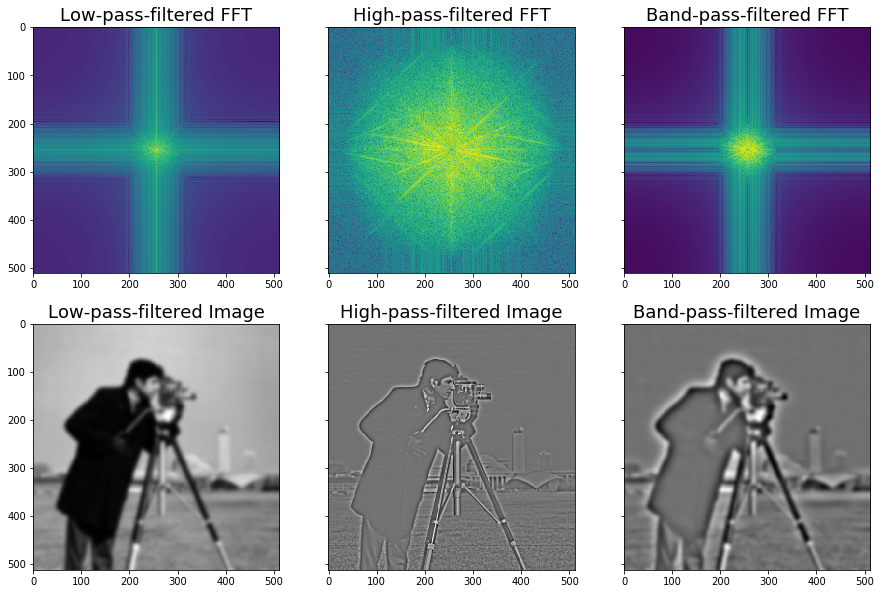

In [15]:
from skimage.filters import gaussian
from skimage import img_as_float

image = img_as_float(image)
gf_image = gaussian(image, 4) # low-pass filter
gf_image2 = gaussian(image, 12) # another low-pass filter

ghpf = image - gf_image # high-pass filter
gbpf = gf_image - gf_image2 # band-pass filter

glpf_fft = fftshift(fftn(gf_image))
ghpf_fft = fftshift(fftn(ghpf))
gbpf_fft = fftshift(fftn(gbpf))


# Plot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), sharey=True)
offset = 10 ** -6 # for avoiding divide-by-zero error

ax[0, 0].imshow(np.log(np.abs(glpf_fft)))
ax[0, 0].set_title('Low-pass-filtered FFT', fontdict=font)
ax[0, 1].imshow(np.log(np.abs(ghpf_fft)))
ax[0, 1].set_title('High-pass-filtered FFT', fontdict=font)
ax[0, 2].imshow(np.log(np.abs(gbpf_fft)))
ax[0, 2].set_title('Band-pass-filtered FFT', fontdict=font)
ax[1, 0].imshow(gf_image, cmap='gray')
ax[1, 0].set_title('Low-pass-filtered Image', fontdict=font)
ax[1, 1].imshow(ghpf, cmap='gray')
ax[1, 1].set_title('High-pass-filtered Image', fontdict=font)
ax[1, 2].imshow(gbpf, cmap='gray')
ax[1, 2].set_title('Band-pass-filtered Image', fontdict=font);